In [8]:
import zipfile
import glob

with zipfile.ZipFile("Twitter.zip", "r") as zip_ref:
    zip_ref.extractall("data")

data_path = glob.glob("data/*")



In [1]:

# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, LSTM
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from utils import preprocess, predict, decode_sentiment

# Word2vec
import gensim

# Utility
import numpy as np
import os
import logging
import time
import pickle
import itertools

# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.9

## HYPERPARAMETERS
# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 5
BATCH_SIZE = 1024


/var/folders/9x/x3rp452s39q3q35j89sr_14m0000gn/T/ipykernel_7540/3520563084.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-04 14:27:50.286314: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/meryem/Desktop/key_phrases_sentiments/.venv/lib/python3.10/site-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecat

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

loading configuration file config.json from cache at /Users/meryem/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3c3da4aa61fe7164e0554d1bb9c9f212ead9627c/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.37.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /Users/meryem/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3c3da4aa61fe7164e0554d1bb9c9f212ead9627c/model.safetensors
Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Al

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

loading file vocab.txt from cache at /Users/meryem/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3c3da4aa61fe7164e0554d1bb9c9f212ead9627c/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /Users/meryem/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3c3da4aa61fe7164e0554d1bb9c9f212ead9627c/tokenizer_config.json
loading file tokenizer.json from cache at /Users/meryem/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3c3da4aa61fe7164e0554d1bb9c9f212ead9627c/tokenizer.json
loading configuration file config.json from cache at /Users/meryem/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3c3da4aa61fe7164e0554d1bb9c9f212ead9627c/config.json
Model config BertConfig {
  "_name_or_path": "bert-large-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradien

Based on https://www.kaggle.com/paoloripamonti/twitter-sentiment-analysis

In [4]:
import glob
data_path = glob.glob("data/*")
df = pd.read_csv(data_path[0], encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}

def map_sentiment(label):
    return decode_map[int(label)]


In [8]:
df["sentiment"] = df["target"].apply(lambda x: map_sentiment(x))
df["key_elements"] = df["text"].apply(lambda x: preprocess(x))

df_train, df_test = train_test_split(df, test_size=1 - TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

KeyboardInterrupt: 

## Preprocess Dataset

CPU times: user 18.5 s, sys: 297 ms, total: 18.8 s
Wall time: 19.3 s


TRAIN size: 1440000
TEST size: 160000


## Word2Vec

In [31]:
documents = [_text.split() for _text in df_train.text] 

In [32]:
w2v_model = gensim.models.word2vec.Word2Vec(window=W2V_WINDOW,
                                            min_count=W2V_MIN_COUNT,
                                            workers=8)

In [33]:
w2v_model.build_vocab(documents)

In [34]:
# Assuming w2v_model is your Word2Vec model in Gensim 4.0.0
words = list(w2v_model.wv.key_to_index.keys())
vocab_size = len(words)
print("Vocab size", vocab_size)


Vocab size 32667


In [35]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(458305070, 607567168)

In [37]:
similar_words = w2v_model.wv.most_similar("business")
print(similar_words)

[('biz', 0.6654356718063354), ('education', 0.652583658695221), ('consulting', 0.647642195224762), ('research', 0.6175902485847473), ('marketing', 0.6100070476531982), ('consumer', 0.6000869274139404), ('networking', 0.5986098051071167), ('admin', 0.595703661441803), ('dept', 0.5921732187271118), ('strategy', 0.5905365347862244)]


## Preprocessing for training

Tokenize text, label encode targets

In [38]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 313441


In [39]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

In [40]:
labels = df_train.target.unique().tolist()
labels.append("NEUTRAL")

In [41]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)

## Embedding Layer

In [44]:
W2V_SIZE = 100  # or the actual dimension of your Word2Vec vectors

embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
    else:
        # Handle the case when the word is not in the Word2Vec model
        # You might want to initialize these with random values or zeros
        embedding_matrix[i] = np.random.rand(W2V_SIZE)  # Example: random values
print(embedding_matrix.shape)


(313441, 100)


In [45]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

## Build model

In [46]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          31344100  
                                                                 
 dropout (Dropout)           (None, 300, 100)          0         
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 31461477 (120.02 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 31344100 (119.57 MB)
_________________________________________________________________


In [47]:
model.compile(loss="binary_crossentropy", optimizer=Adam(5e-4), metrics=["accuracy"])

In [48]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

## Train!

In [49]:
H = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.05, verbose=1, callbacks=callbacks)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1336/1336 [==============================] - ETA: 0s - loss: 0.5347 - accuracy: 0.7295WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x201b74040> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


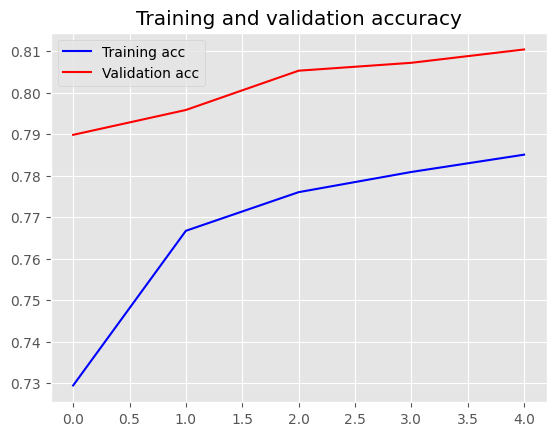

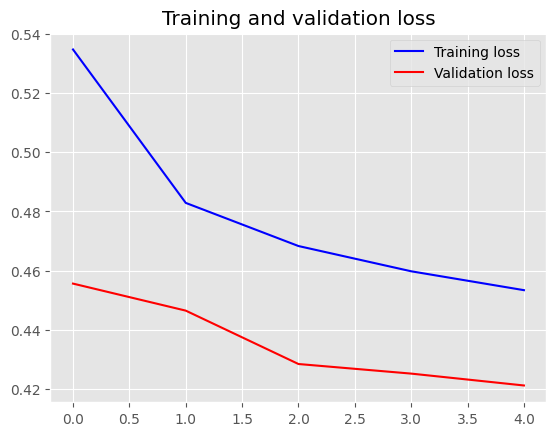

In [51]:
# Check the keys in H.history
print(H.history.keys())

# Use 'accuracy' instead of 'acc' if necessary
if 'accuracy' in H.history:
    acc = H.history['accuracy']
    val_acc = H.history['val_accuracy']
else:
    acc = H.history['acc']
    val_acc = H.history['val_acc']

loss = H.history['loss']
val_loss = H.history['val_loss']

epochs = range(len(acc))

plt.style.use("ggplot")

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


## Testing

In [52]:
%%time
score = model.evaluate(x_test, y_test, batch_size=5000)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

32/32 [==============================] - 94s 3s/step - loss: 0.4175 - accuracy: 0.8107

ACCURACY: 0.8106874823570251
LOSS: 0.4174586534500122
CPU times: user 9min 49s, sys: 2min 33s, total: 12min 23s
Wall time: 1min 34s


In [53]:
predict(model, tokenizer, ["The house is on fire"])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 342ms/step


{'label': ['POSITIVE'],
 'score': array([[0.70730233]], dtype=float32),
 'elapsed_time': 0.40616822242736816}

In [54]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

20/20 [==============================] - 92s 5s/step
CPU times: user 10min 23s, sys: 2min 21s, total: 12min 45s
Wall time: 1min 32s


In [55]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

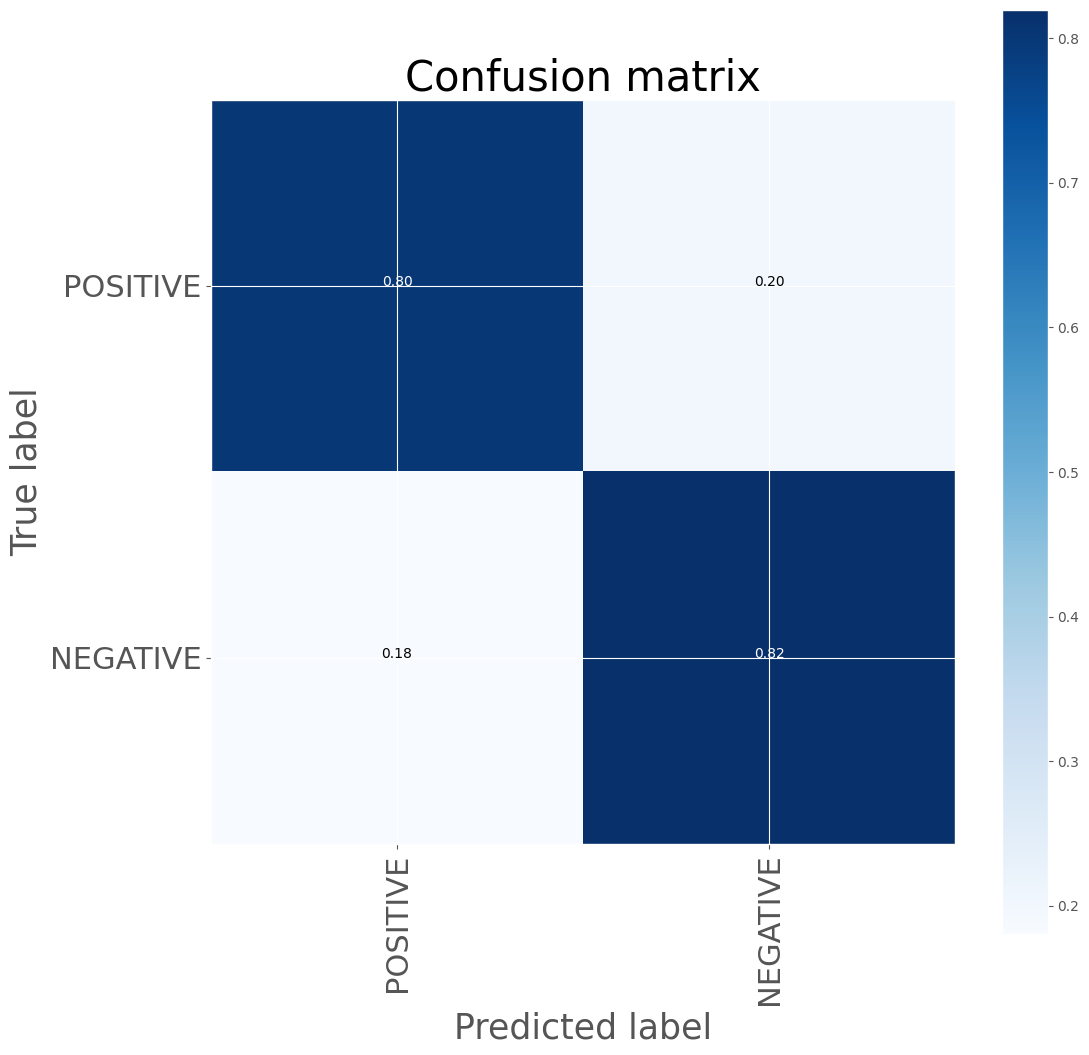

In [56]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [57]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.82      0.80      0.81     79812
    POSITIVE       0.81      0.82      0.81     80188

    accuracy                           0.81    160000
   macro avg       0.81      0.81      0.81    160000
weighted avg       0.81      0.81      0.81    160000


In [58]:
model.save("twitter.h5")
w2v_model.save("twitter.w2v")
pickle.dump(tokenizer, open("tokenizer.p", "wb"), protocol=0)
pickle.dump(encoder, open("encoder.p", "wb"), protocol=0)

/Users/meryem/Desktop/Twitter-Sentiment-Analysis-Flask-App/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
